In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import RigidTendonArm, RigidTendonArmThelen
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger, TrainingPlotter
from MotorNet.tasks.tasks import TaskStaticTarget, TaskDelayedReach, TaskStaticTargetWithPerturbations

from MotorNet.nets.custommodels import MotorNetModel

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

tensorflow version: 2.4.1


In [2]:
arm = RigidTendonArmThelen(timestep=0.01, proprioceptive_delay=0.04, visual_delay=0.013,
          excitation_noise_sd=0.001) # 0.005
regularizer = 10**-8
feedback_noise = 10**-4
task = TaskStaticTargetWithPerturbations(plant=arm)
cell = GRUController(plant=arm, n_units=200, kernel_regularizer=regularizer, activity_regularizer=regularizer, recurrent_regularizer=regularizer,
                     name='cell',
                     proprioceptive_noise_sd=feedback_noise, visual_noise_sd=feedback_noise,
                     perturbation_dim_start=task.get_perturbation_dim_start())

# declare inputs
targets = Input((None, arm.state_dim,), name='target')
inputs = Input((None, task.get_input_dim()))
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
          Input((arm.n_muscles*2, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.space_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(inputs, initial_state=state0)
control_rnn = MotorNetModel(inputs=[inputs, state0], outputs=states_out, name='controller')

# pull the losses from the task itself
[losses, loss_weights] = task.get_losses()

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
init_states = cell.get_initial_state(batch_size=3, inputs=task.get_initial_state())
trainingplot_callback = TrainingPlotter(task, init_states, plot_freq=100)
control_rnn.summary()
losses

Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 6, 6)]       0                                            
_________________________________________________________________________________________

{'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_squared_loss.<locals>.loss(y_true, y_pred)>}

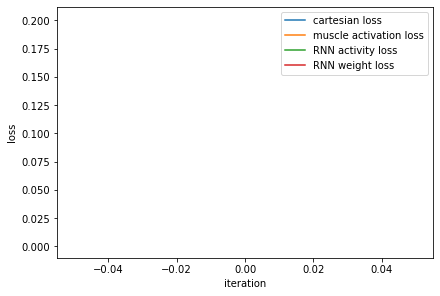

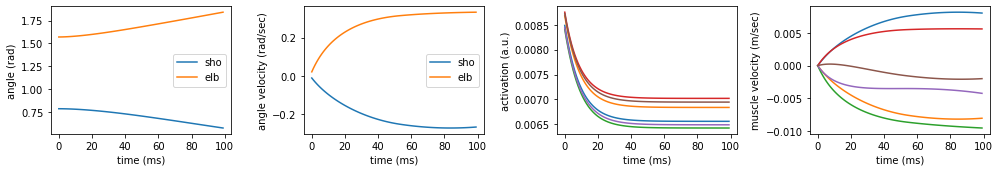

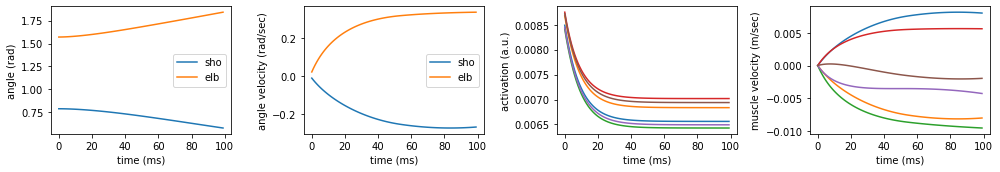

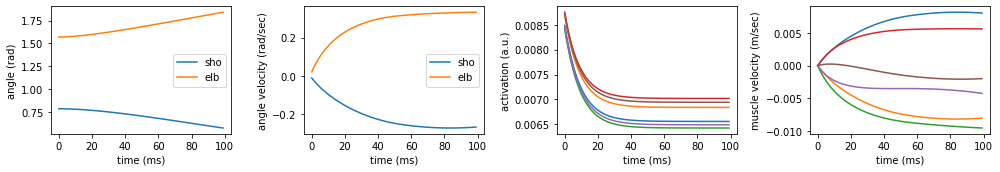

  16/3000 [..............................] - ETA: 21:29 - loss: 0.2081 - RNN_loss: 0.2080 - RNN_4_loss: 0.0070

KeyboardInterrupt: 

In [3]:
#name = '50gru_1e-3dt_weights'
#control_rnn.load_weights(os.getcwd() + '/saved_models/' + name)

batch_size = 32
dataset_size = 3000 * batch_size
n_t = int(1.0 / arm.dt)

with tf.device('/cpu:0'):
    for _ in range(1):
        init_states = cell.get_initial_state(batch_size=dataset_size, inputs=task.get_initial_state())
        [inputs, targets] = task.generate(n_timesteps=n_t, batch_size=dataset_size)
        control_rnn.fit([inputs, init_states], targets, epochs=1, batch_size=batch_size, verbose=1, callbacks=[batchlog_callback, trainingplot_callback], shuffle=False)



In [ ]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


In [ ]:
init_states = cell.get_initial_state(batch_size=50, inputs=task.get_initial_state())
[inputs, targets] = task.generate(n_timesteps=n_t, batch_size=50)

results = control_rnn([inputs, init_states], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(targets[:, -1, 0], targets[:, -1, 1])

plt.subplot(122)
#plot_pos_over_time(cart_results=c_results - targets)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')

In [ ]:
trial = 1
plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

plt.subplot(141)
plt.plot(inputs[0,:,:])

plt.subplot(142)
plt.plot(targets[0,:,:])

plt.subplot(143)
plt.plot(inputs[1,:,:])

plt.subplot(144)
plt.plot(targets[1,:,:])

plt.show()

In [ ]:
for trial in range(10):
    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (rad)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')

    plt.subplot(144)
    plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('muscle velocity (m/sec)')

    plt.show()

In [ ]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()



In [ ]:
### To apply a set of weights from a previous iteration weight set w1
# control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-3dt_weights'
# control_rnn.save_weights(os.getcwd() + '/saved_models/' + name)

In [ ]:
from MotorNet.utils.plotor import animate_arm_trajectory

results_batch_size = tf.shape(j_results)
to_animate = np.expand_dims(np.transpose(np.reshape(np.transpose(j_results.numpy()), (results_batch_size[2], -1), order='F')), axis=0)

A = j_results[0:1]

animate_arm_trajectory(to_animate[:,0:1500,:], arm, path_name = './Arm_animation.gif')
#animate_arm_trajectory(j_results[0:1], arm, path_name = './Arm_animation.gif')























